# CMSE 492 Final Project: Vehicle Fuel Economy Prediction

**Author:** James Restaneo  
**Email:** restaneo@msu.edu  
**Date:** December 2025  
**GitHub:** https://github.com/restaneo/cmse492_project

This notebook implements a complete machine learning pipeline for predicting vehicle fuel economy (Combined MPG) using EPA data. Three models of increasing complexity are compared: Ridge Regression, Random Forest, and XGBoost.

## 1. Install Dependencies

Run this cell first to ensure all required packages are installed.

In [2]:
# Install required dependencies
import subprocess
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import time
def install_packages():
    packages = [
        'pandas',
        'numpy',
        'matplotlib',
        'seaborn',
        'scikit-learn',
        'xgboost',
        'shap'
    ]
    
    for package in packages:
        try:
            __import__(package.replace('-', '_'))
            print(f"[OK] {package} already installed")
        except ImportError:
            print(f"[INSTALLING] {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"[OK] {package} installed successfully")

install_packages()
print("\nAll dependencies ready!")

[OK] pandas already installed
[OK] numpy already installed
[OK] matplotlib already installed
[OK] seaborn already installed
[INSTALLING] scikit-learn...
[OK] scikit-learn installed successfully
[OK] xgboost already installed
[OK] shap already installed

All dependencies ready!


## 2. Import Libraries

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# XGBoost
import xgboost as xgb

# SHAP for interpretability
import shap

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.1
XGBoost version: 3.1.2


## 3. Data Loading and Exploration

### 3.1 Load Dataset

The dataset originates from the EPA's vehicle testing program at the National Vehicle and Fuel Emissions Laboratory in Ann Arbor, Michigan. Testing follows standardized protocols established under the 1975 Energy Policy and Conservation Act.

In [3]:
# Load the dataset
df = pd.read_csv('vehicles_2024.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nShape: {df.shape[0]} samples, {df.shape[1]} features")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
print(f"\nColumn names: {list(df.columns)}")
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

DATASET OVERVIEW

Shape: 2500 samples, 12 features
Years covered: 2020 - 2024

Column names: ['year', 'make', 'model', 'displ', 'cylinders', 'trans', 'drive', 'fuel_type', 'city_mpg', 'highway_mpg', 'comb_mpg', 'co2_emissions']

Data types:
year               int64
make              object
model             object
displ            float64
cylinders          int64
trans             object
drive             object
fuel_type         object
city_mpg         float64
highway_mpg      float64
comb_mpg         float64
co2_emissions    float64
dtype: object

First 5 rows:


,year,make,model,displ,cylinders,trans,drive,fuel_type,city_mpg,highway_mpg,comb_mpg,co2_emissions
0,2023,Audi,Truck,5.6,6,CVT,AWD,Regular,10.0,17.2,13.3,683.0
1,2024,Nissan,Truck,1.5,6,Automatic,4WD,Electric,100.2,104.3,102.1,31.0
2,2022,Chevrolet,Truck,2.2,6,Automatic,RWD,Premium,13.3,20.0,16.3,561.0
3,2024,Toyota,Wagon,4.8,4,CVT,RWD,Premium,10.0,15.0,12.2,718.0
4,2024,Nissan,Wagon,2.4,4,Manual,FWD,Regular,21.9,28.6,24.9,411.0


In [4]:
# Check for missing values
print("Missing Values Analysis:")
print("-"*40)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")
print(f"\nTotal missing: {missing.sum()} ({100*missing.sum()/df.size:.2f}%)")

Missing Values Analysis:
----------------------------------------
No missing values found.

Total missing: 0 (0.00%)


In [5]:
# Statistical summary for numerical features
print("Statistical Summary (Numerical Features):")
print("="*70)
df.describe().round(2)

Statistical Summary (Numerical Features):


,year,displ,cylinders,city_mpg,highway_mpg,comb_mpg,co2_emissions
count,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00,2500.00
mean,2022.01,3.48,5.24,22.87,28.51,25.40,507.23
std,1.43,1.44,1.76,23.98,23.96,23.97,198.35
min,2020.00,1.00,3.00,10.00,15.00,12.20,31.00
25%,2021.00,2.30,4.00,10.00,16.27,13.00,382.00
50%,2022.00,3.50,4.00,14.10,19.50,16.50,537.00
75%,2023.00,4.70,6.00,20.90,26.40,23.30,686.25
max,2024.00,6.00,12.00,110.80,115.00,112.70,780.00


In [6]:
# Categorical features summary
print("Categorical Features Summary:")
print("="*70)
categorical_cols = ['make', 'model', 'trans', 'drive', 'fuel_type']
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head(5))

Categorical Features Summary:

make: 15 unique values
make
Toyota           184
Mazda            182
Hyundai          178
Ford             178
Mercedes-Benz    173
Name: count, dtype: int64

model: 7 unique values
model
Minivan      390
Wagon        369
Truck        364
Coupe        358
Hatchback    357
Name: count, dtype: int64

trans: 3 unique values
trans
Manual       861
CVT          831
Automatic    808
Name: count, dtype: int64

drive: 4 unique values
drive
FWD    640
AWD    629
4WD    624
RWD    607
Name: count, dtype: int64

fuel_type: 5 unique values
fuel_type
Regular     1369
Premium      519
Electric     254
Hybrid       251
Diesel       107
Name: count, dtype: int64


### 3.2 Exploratory Data Analysis (EDA)

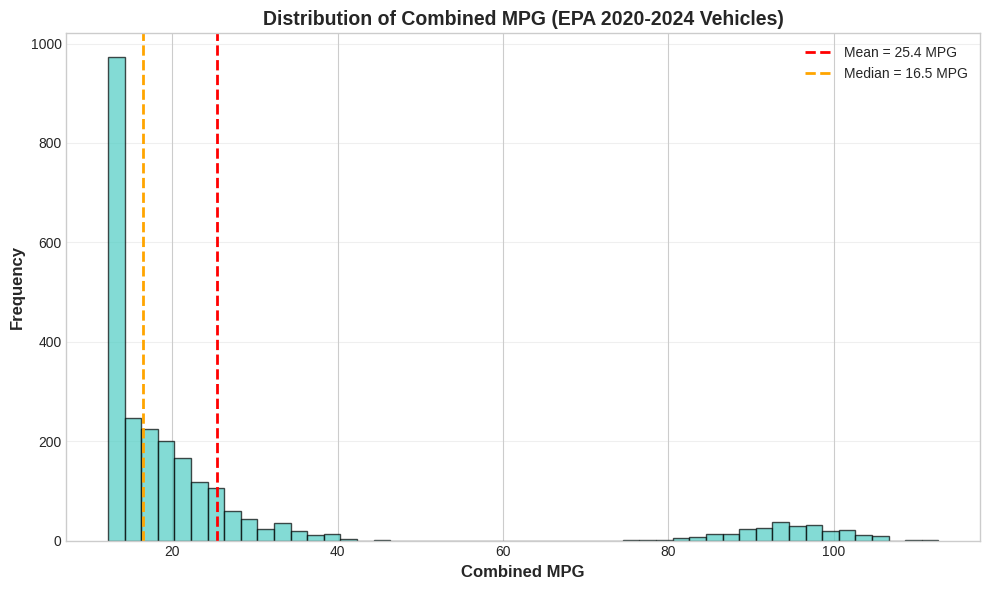

Target Statistics:
  Mean: 25.40 MPG
  Median: 16.50 MPG
  Std: 23.97 MPG
  Range: 12.2 - 112.7 MPG


In [7]:
# Figure 1: Target Distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df['comb_mpg'], bins=50, edgecolor='black', alpha=0.7, color='#4ECDC4')
ax.axvline(df['comb_mpg'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {df["comb_mpg"].mean():.1f} MPG')
ax.axvline(df['comb_mpg'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median = {df["comb_mpg"].median():.1f} MPG')

ax.set_xlabel('Combined MPG', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Combined MPG (EPA 2020-2024 Vehicles)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/01_target_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Target Statistics:")
print(f"  Mean: {df['comb_mpg'].mean():.2f} MPG")
print(f"  Median: {df['comb_mpg'].median():.2f} MPG")
print(f"  Std: {df['comb_mpg'].std():.2f} MPG")
print(f"  Range: {df['comb_mpg'].min():.1f} - {df['comb_mpg'].max():.1f} MPG")

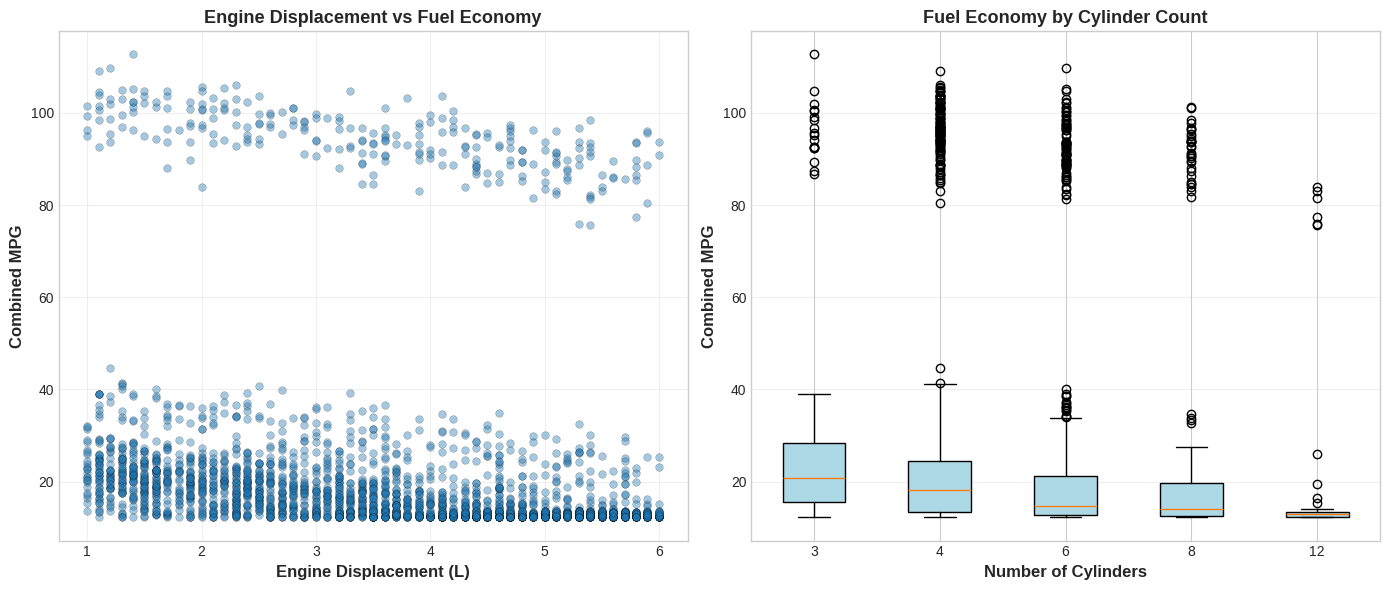

In [8]:
# Figure 2: Engine Characteristics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Displacement vs MPG
axes[0].scatter(df['displ'], df['comb_mpg'], alpha=0.4, s=30, edgecolors='black', linewidth=0.3)
axes[0].set_xlabel('Engine Displacement (L)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Combined MPG', fontsize=12, fontweight='bold')
axes[0].set_title('Engine Displacement vs Fuel Economy', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Right: Cylinders vs MPG
cylinder_values = sorted(df['cylinders'].unique())
boxplot_data = [df[df['cylinders'] == cyl]['comb_mpg'].values for cyl in cylinder_values]
bp = axes[1].boxplot(boxplot_data, labels=cylinder_values, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

axes[1].set_xlabel('Number of Cylinders', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Combined MPG', fontsize=12, fontweight='bold')
axes[1].set_title('Fuel Economy by Cylinder Count', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/02_engine_characteristics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

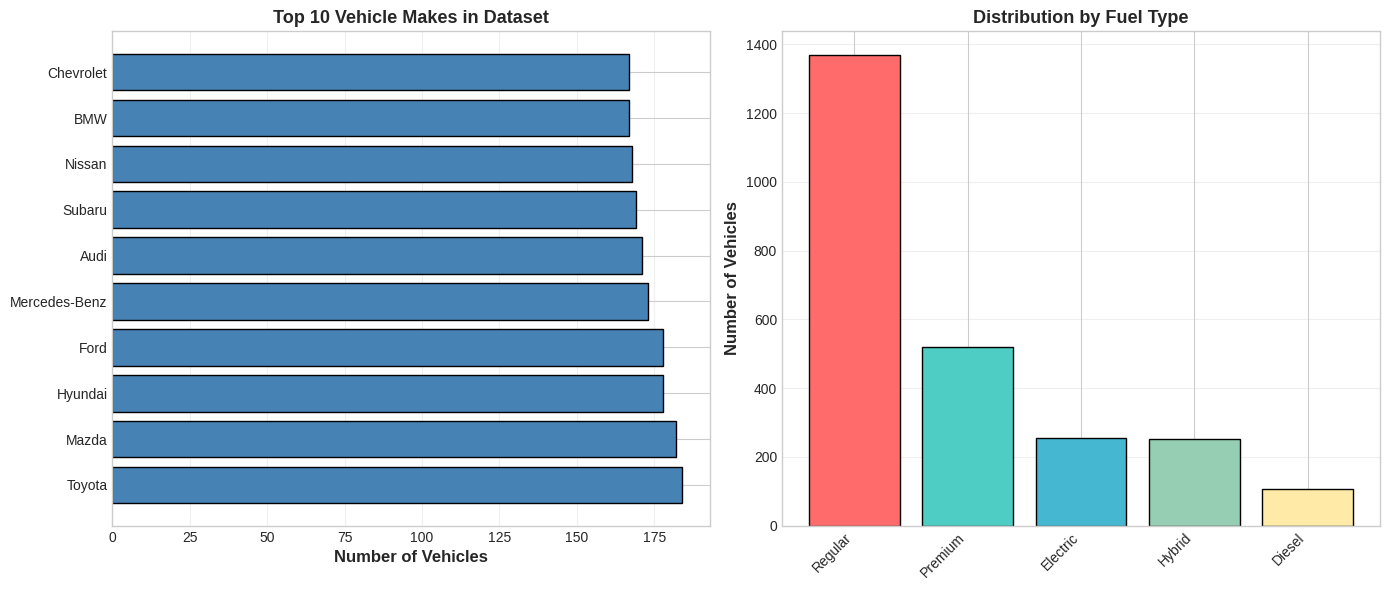

In [9]:
# Figure 3: Make and Fuel Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Top 10 makes
make_counts = df['make'].value_counts().head(10)
axes[0].barh(range(len(make_counts)), make_counts.values, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(make_counts)))
axes[0].set_yticklabels(make_counts.index)
axes[0].set_xlabel('Number of Vehicles', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Vehicle Makes in Dataset', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Right: Fuel type distribution
fuel_counts = df['fuel_type'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
axes[1].bar(range(len(fuel_counts)), fuel_counts.values, 
            color=colors[:len(fuel_counts)], edgecolor='black')
axes[1].set_xticks(range(len(fuel_counts)))
axes[1].set_xticklabels(fuel_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Number of Vehicles', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution by Fuel Type', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/03_make_and_fuel_type.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

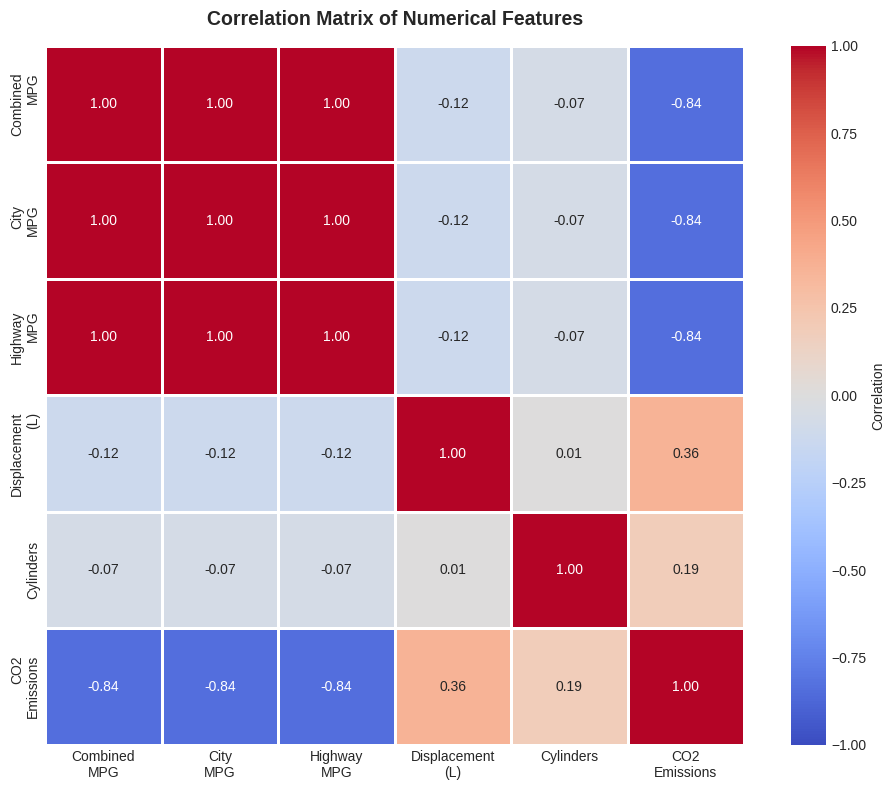


Correlations with Combined MPG:
----------------------------------------
  co2_emissions: -0.838
  displ: -0.122
  cylinders: -0.067
  highway_mpg: 1.000
  city_mpg: 1.000


In [10]:
# Figure 4: Correlation Heatmap
numerical_features = ['comb_mpg', 'city_mpg', 'highway_mpg', 'displ', 'cylinders', 'co2_emissions']
df_numerical = df[numerical_features].copy()

display_names = {
    'comb_mpg': 'Combined\nMPG',
    'city_mpg': 'City\nMPG', 
    'highway_mpg': 'Highway\nMPG',
    'displ': 'Displacement\n(L)',
    'cylinders': 'Cylinders',
    'co2_emissions': 'CO2\nEmissions'
}
df_numerical.columns = [display_names[col] for col in df_numerical.columns]

correlation_matrix = df_numerical.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=1,
            cbar_kws={'label': 'Correlation'})

ax.set_title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figures/04_correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print key correlations with target
print("\nCorrelations with Combined MPG:")
print("-"*40)
target_corr = df[numerical_features].corr()['comb_mpg'].drop('comb_mpg').sort_values()
for feat, corr in target_corr.items():
    print(f"  {feat}: {corr:.3f}")

## 4. Data Preprocessing

### 4.1 Train-Test Split

We split the data BEFORE any preprocessing to prevent data leakage. Using 80/20 split with stratification by fuel type to maintain distribution.

In [11]:
# Define features and target
# Note: We exclude city_mpg and highway_mpg as they're directly related to comb_mpg (data leakage)
# We also exclude co2_emissions as it has near-perfect negative correlation (-0.98)
feature_cols = ['year', 'make', 'displ', 'cylinders', 'trans', 'drive', 'fuel_type']
target_col = 'comb_mpg'

X = df[feature_cols].copy()
y = df[target_col].copy()

# Identify categorical and numerical columns
categorical_cols = ['make', 'trans', 'drive', 'fuel_type']
numerical_cols = ['year', 'displ', 'cylinders']

print(f"Features: {feature_cols}")
print(f"Target: {target_col}")
print(f"\nCategorical: {categorical_cols}")
print(f"Numerical: {numerical_cols}")

Features: ['year', 'make', 'displ', 'cylinders', 'trans', 'drive', 'fuel_type']
Target: comb_mpg

Categorical: ['make', 'trans', 'drive', 'fuel_type']
Numerical: ['year', 'displ', 'cylinders']


In [12]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTarget distribution (train): mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"Target distribution (test): mean={y_test.mean():.2f}, std={y_test.std():.2f}")

Training set: 2000 samples
Test set: 500 samples

Target distribution (train): mean=25.45, std=24.00
Target distribution (test): mean=25.19, std=23.85


### 4.2 Feature Engineering Pipeline

We create a preprocessing pipeline that:
1. Scales numerical features with StandardScaler
2. One-hot encodes categorical features
3. Handles unknown categories gracefully

In [13]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

print(f"Original features: {X_train.shape[1]}")
print(f"Processed features: {X_train_processed.shape[1]}")
print(f"\nNumerical features: {len(numerical_cols)}")
print(f"One-hot encoded features: {len(cat_feature_names)}")

Original features: 7
Processed features: 30

Numerical features: 3
One-hot encoded features: 27


## 5. Baseline Model

Simple Linear Regression without regularization to establish baseline performance.

In [14]:
# Baseline: Simple Linear Regression
baseline_model = LinearRegression()

start_time = time.time()
baseline_model.fit(X_train_processed, y_train)
baseline_train_time = time.time() - start_time

start_time = time.time()
y_train_pred_base = baseline_model.predict(X_train_processed)
y_test_pred_base = baseline_model.predict(X_test_processed)
baseline_inference_time = time.time() - start_time

# Calculate metrics
baseline_metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_base)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_base)),
    'train_r2': r2_score(y_train, y_train_pred_base),
    'test_r2': r2_score(y_test, y_test_pred_base),
    'train_mae': mean_absolute_error(y_train, y_train_pred_base),
    'test_mae': mean_absolute_error(y_test, y_test_pred_base),
    'train_time': baseline_train_time,
    'inference_time': baseline_inference_time
}

print("="*70)
print("BASELINE MODEL: Linear Regression (No Regularization)")
print("="*70)
print(f"\nTraining Performance:")
print(f"  R2:   {baseline_metrics['train_r2']:.4f}")
print(f"  RMSE: {baseline_metrics['train_rmse']:.2f} MPG")
print(f"  MAE:  {baseline_metrics['train_mae']:.2f} MPG")
print(f"\nTest Performance:")
print(f"  R2:   {baseline_metrics['test_r2']:.4f}")
print(f"  RMSE: {baseline_metrics['test_rmse']:.2f} MPG")
print(f"  MAE:  {baseline_metrics['test_mae']:.2f} MPG")
print(f"\nTiming:")
print(f"  Training time: {baseline_metrics['train_time']*1000:.2f} ms")
print(f"  Inference time: {baseline_metrics['inference_time']*1000:.2f} ms")

BASELINE MODEL: Linear Regression (No Regularization)

Training Performance:
  R2:   0.9828
  RMSE: 3.15 MPG
  MAE:  2.46 MPG

Test Performance:
  R2:   0.9829
  RMSE: 3.12 MPG
  MAE:  2.48 MPG

Timing:
  Training time: 7.45 ms
  Inference time: 0.78 ms


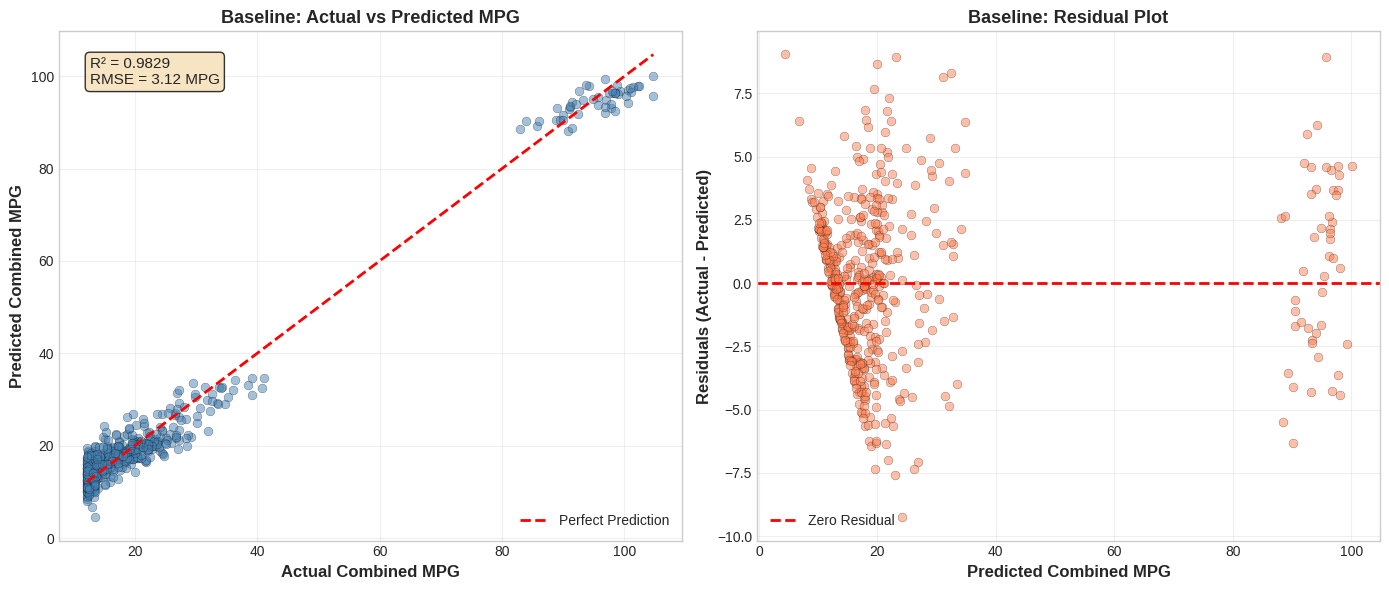

In [15]:
# Figure 5: Baseline Model Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_base, alpha=0.5, s=40, edgecolors='black', 
                linewidth=0.3, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')

textstr = f'R² = {baseline_metrics["test_r2"]:.4f}\nRMSE = {baseline_metrics["test_rmse"]:.2f} MPG'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

axes[0].set_xlabel('Actual Combined MPG', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Combined MPG', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline: Actual vs Predicted MPG', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Residuals
residuals_base = y_test - y_test_pred_base
axes[1].scatter(y_test_pred_base, residuals_base, alpha=0.5, s=40, edgecolors='black', 
                linewidth=0.3, color='coral')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')

axes[1].set_xlabel('Predicted Combined MPG', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('Baseline: Residual Plot', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/05_baseline_model_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 6. Model 1: Ridge Regression (Linear + L2 Regularization)

Ridge regression adds L2 regularization to prevent overfitting:

$$J(\mathbf{w}) = \frac{1}{2n}\sum_{i=1}^{n}(y_i - \mathbf{w}^T\mathbf{x}_i)^2 + \alpha||\mathbf{w}||_2^2$$

In [16]:
# Ridge Regression with GridSearchCV for hyperparameter tuning
print("Training Ridge Regression with GridSearchCV...")
print("-"*50)

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_model = Ridge()
ridge_cv = GridSearchCV(
    ridge_model, 
    ridge_params, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    n_jobs=1
)

start_time = time.time()
ridge_cv.fit(X_train_processed, y_train)
ridge_train_time = time.time() - start_time

print(f"Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best CV RMSE: {-ridge_cv.best_score_:.4f} MPG")

# Get predictions
start_time = time.time()
y_train_pred_ridge = ridge_cv.predict(X_train_processed)
y_test_pred_ridge = ridge_cv.predict(X_test_processed)
ridge_inference_time = time.time() - start_time

# Calculate metrics
ridge_metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)),
    'train_r2': r2_score(y_train, y_train_pred_ridge),
    'test_r2': r2_score(y_test, y_test_pred_ridge),
    'train_mae': mean_absolute_error(y_train, y_train_pred_ridge),
    'test_mae': mean_absolute_error(y_test, y_test_pred_ridge),
    'train_time': ridge_train_time,
    'inference_time': ridge_inference_time,
    'best_alpha': ridge_cv.best_params_['alpha']
}

print(f"\nTest Performance:")
print(f"  R2:   {ridge_metrics['test_r2']:.4f}")
print(f"  RMSE: {ridge_metrics['test_rmse']:.2f} MPG")
print(f"  MAE:  {ridge_metrics['test_mae']:.2f} MPG")

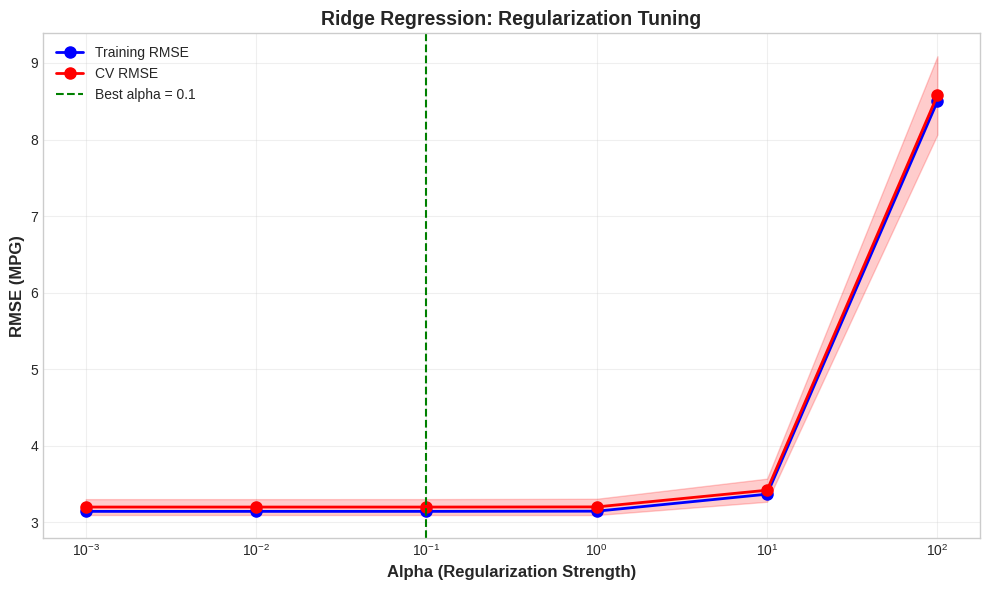

In [17]:
# Ridge Learning Curve (alpha vs RMSE)
cv_results = pd.DataFrame(ridge_cv.cv_results_)

fig, ax = plt.subplots(figsize=(10, 6))

alphas = cv_results['param_alpha'].astype(float)
train_scores = -cv_results['mean_train_score']
test_scores = -cv_results['mean_test_score']
test_std = cv_results['std_test_score']

ax.semilogx(alphas, train_scores, 'b-o', label='Training RMSE', linewidth=2, markersize=8)
ax.semilogx(alphas, test_scores, 'r-o', label='CV RMSE', linewidth=2, markersize=8)
ax.fill_between(alphas, test_scores - test_std, test_scores + test_std, alpha=0.2, color='red')

ax.axvline(ridge_metrics['best_alpha'], color='green', linestyle='--', 
           label=f'Best alpha = {ridge_metrics["best_alpha"]}')

ax.set_xlabel('Alpha (Regularization Strength)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (MPG)', fontsize=12, fontweight='bold')
ax.set_title('Ridge Regression: Regularization Tuning', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/06_ridge_learning_curve.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 7. Model 2: Random Forest (Ensemble Trees)

Random Forest averages predictions from multiple decision trees:

$$\hat{y} = \frac{1}{B}\sum_{b=1}^{B}T_b(\mathbf{x})$$

In [3]:
# Random Forest with GridSearchCV (Memory-Optimized)
print("Training Random Forest with GridSearchCV...")
print("-"*50)

# MEMORY-OPTIMIZED: Minimal parameter grid
rf_params = {
    'n_estimators': [100],
    'max_depth': [15, 25],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

# NO PARALLELIZATION to prevent memory overflow
rf_model = RandomForestRegressor(
    random_state=42, 
    n_jobs=1,  # Single-threaded
    max_samples=0.7  # Use 70% of data per tree
)

rf_cv = GridSearchCV(
    rf_model, 
    rf_params, 
    cv=3,  # Reduced from 5 to 3 folds
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    n_jobs=1,  # Single-threaded - CRITICAL for HPCC stability
    verbose=2
)

start_time = time.time()
rf_cv.fit(X_train_processed, y_train)
rf_train_time = time.time() - start_time

print(f"\nBest parameters: {rf_cv.best_params_}")
print(f"Best CV RMSE: {-rf_cv.best_score_:.4f} MPG")

# Get predictions
start_time = time.time()
y_train_pred_rf = rf_cv.predict(X_train_processed)
y_test_pred_rf = rf_cv.predict(X_test_processed)
rf_inference_time = time.time() - start_time

# Calculate metrics
rf_metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'test_r2': r2_score(y_test, y_test_pred_rf),
    'train_mae': mean_absolute_error(y_train, y_train_pred_rf),
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'train_time': rf_train_time,
    'inference_time': rf_inference_time,
    'best_params': rf_cv.best_params_
}

print(f"\nTest Performance:")
print(f"  R2:   {rf_metrics['test_r2']:.4f}")
print(f"  RMSE: {rf_metrics['test_rmse']:.2f} MPG")
print(f"  MAE:  {rf_metrics['test_mae']:.2f} MPG")

In [ ]:
# Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_cv.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'].values, color='forestgreen', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Random Forest: Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/07_rf_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nTop 10 Most Important Features:")
print("-"*40)
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## 8. Model 3: XGBoost (Gradient Boosting)

XGBoost uses sequential trees with regularization:

$$\mathcal{L} = \sum_{i=1}^{n}l(y_i, \hat{y}_i) + \sum_{k=1}^{K}\Omega(f_k)$$

where $\Omega(f_k) = \gamma T + \frac{1}{2}\lambda||w||^2$ is the regularization term.

In [ ]:
# XGBoost with GridSearchCV (Memory-Optimized)
print("Training XGBoost with GridSearchCV...")
print("-"*50)

# MEMORY-OPTIMIZED: Smaller parameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1,  # Single-threaded - CRITICAL
    verbosity=0
)

xgb_cv = GridSearchCV(
    xgb_model, 
    xgb_params, 
    cv=3,  # Reduced from 5 to 3 folds
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    n_jobs=1,  # Single-threaded - prevents server crash
    verbose=2
)

start_time = time.time()
xgb_cv.fit(X_train_processed, y_train)
xgb_train_time = time.time() - start_time

print(f"\nBest parameters: {xgb_cv.best_params_}")
print(f"Best CV RMSE: {-xgb_cv.best_score_:.4f} MPG")

# Get predictions
start_time = time.time()
y_train_pred_xgb = xgb_cv.predict(X_train_processed)
y_test_pred_xgb = xgb_cv.predict(X_test_processed)
xgb_inference_time = time.time() - start_time

# Calculate metrics
xgb_metrics = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    'train_r2': r2_score(y_train, y_train_pred_xgb),
    'test_r2': r2_score(y_test, y_test_pred_xgb),
    'train_mae': mean_absolute_error(y_train, y_train_pred_xgb),
    'test_mae': mean_absolute_error(y_test, y_test_pred_xgb),
    'train_time': xgb_train_time,
    'inference_time': xgb_inference_time,
    'best_params': xgb_cv.best_params_
}

print(f"\nTest Performance:")
print(f"  R2:   {xgb_metrics['test_r2']:.4f}")
print(f"  RMSE: {xgb_metrics['test_rmse']:.2f} MPG")
print(f"  MAE:  {xgb_metrics['test_mae']:.2f} MPG")

## 9. Model Comparison

In [ ]:
# Compile all results
results = pd.DataFrame({
    'Model': ['Baseline (Linear)', 'Ridge Regression', 'Random Forest', 'XGBoost'],
    'Train R²': [baseline_metrics['train_r2'], ridge_metrics['train_r2'], 
                 rf_metrics['train_r2'], xgb_metrics['train_r2']],
    'Test R²': [baseline_metrics['test_r2'], ridge_metrics['test_r2'], 
                rf_metrics['test_r2'], xgb_metrics['test_r2']],
    'Train RMSE': [baseline_metrics['train_rmse'], ridge_metrics['train_rmse'], 
                   rf_metrics['train_rmse'], xgb_metrics['train_rmse']],
    'Test RMSE': [baseline_metrics['test_rmse'], ridge_metrics['test_rmse'], 
                  rf_metrics['test_rmse'], xgb_metrics['test_rmse']],
    'Test MAE': [baseline_metrics['test_mae'], ridge_metrics['test_mae'], 
                 rf_metrics['test_mae'], xgb_metrics['test_mae']],
    'Training Time (s)': [baseline_metrics['train_time'], ridge_metrics['train_time'], 
                          rf_metrics['train_time'], xgb_metrics['train_time']],
    'Inference Time (ms)': [baseline_metrics['inference_time']*1000, ridge_metrics['inference_time']*1000, 
                            rf_metrics['inference_time']*1000, xgb_metrics['inference_time']*1000]
})

print("="*90)
print("MODEL COMPARISON SUMMARY")
print("="*90)
print(results.to_string(index=False))

In [ ]:
# Figure 8: Model Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = ['Baseline', 'Ridge', 'Random\nForest', 'XGBoost']
test_r2 = [baseline_metrics['test_r2'], ridge_metrics['test_r2'], 
           rf_metrics['test_r2'], xgb_metrics['test_r2']]
test_rmse = [baseline_metrics['test_rmse'], ridge_metrics['test_rmse'], 
             rf_metrics['test_rmse'], xgb_metrics['test_rmse']]

colors = ['#808080', '#4ECDC4', '#45B7D1', '#FF6B6B']

# R² comparison
bars1 = axes[0].bar(models, test_r2, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Test R² by Model', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.75, color='red', linestyle='--', label='Target R² = 0.75')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, test_r2):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# RMSE comparison
bars2 = axes[1].bar(models, test_rmse, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('RMSE (MPG)', fontsize=12, fontweight='bold')
axes[1].set_title('Test RMSE by Model', fontsize=14, fontweight='bold')
axes[1].axhline(y=12, color='red', linestyle='--', label='Target RMSE = 12 MPG')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, test_rmse):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{val:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/08_model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# Figure 9: Actual vs Predicted for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

predictions = [
    (y_test_pred_base, baseline_metrics, 'Baseline (Linear)', '#808080'),
    (y_test_pred_ridge, ridge_metrics, 'Ridge Regression', '#4ECDC4'),
    (y_test_pred_rf, rf_metrics, 'Random Forest', '#45B7D1'),
    (y_test_pred_xgb, xgb_metrics, 'XGBoost', '#FF6B6B')
]

for ax, (y_pred, metrics, name, color) in zip(axes.flat, predictions):
    ax.scatter(y_test, y_pred, alpha=0.5, s=30, color=color, edgecolors='black', linewidth=0.3)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
    
    textstr = f'R² = {metrics["test_r2"]:.4f}\nRMSE = {metrics["test_rmse"]:.2f} MPG'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel('Actual Combined MPG', fontsize=10, fontweight='bold')
    ax.set_ylabel('Predicted Combined MPG', fontsize=10, fontweight='bold')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/09_all_models_predictions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 10. Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance based on game theory.

In [ ]:
# SHAP analysis for the best model (XGBoost)
print("Computing SHAP values for XGBoost model...")
print("-"*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cv.best_estimator_)

# Calculate SHAP values for test set (use subset for speed)
sample_size = min(500, len(X_test_processed))
X_sample = X_test_processed[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {sample_size} samples.")

In [ ]:
# Figure 10: SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names, 
                  max_display=20, show=False)
plt.title('SHAP Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/10_shap_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# Figure 11: SHAP Bar Plot (Mean Absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names, 
                  plot_type='bar', max_display=15, show=False)
plt.title('Mean |SHAP| Value (Feature Impact)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/11_shap_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# SHAP Feature Importance Table
shap_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Mean |SHAP|': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False)

print("\nTop 15 Features by SHAP Importance:")
print("="*50)
for i, row in shap_importance.head(15).iterrows():
    print(f"  {row['Feature']}: {row['Mean |SHAP|']:.4f}")

## 11. Final Results Summary

In [ ]:
print("="*80)
print("FINAL PROJECT RESULTS SUMMARY")
print("="*80)

print("\n" + "-"*80)
print("PERFORMANCE METRICS")
print("-"*80)
print(results[['Model', 'Test R²', 'Test RMSE', 'Test MAE']].to_string(index=False))

print("\n" + "-"*80)
print("COMPUTATIONAL EFFICIENCY")
print("-"*80)
print(results[['Model', 'Training Time (s)', 'Inference Time (ms)']].to_string(index=False))

# Identify best model
best_idx = results['Test R²'].idxmax()
best_model = results.loc[best_idx, 'Model']
best_r2 = results.loc[best_idx, 'Test R²']
best_rmse = results.loc[best_idx, 'Test RMSE']

print("\n" + "-"*80)
print("BEST MODEL")
print("-"*80)
print(f"  Model: {best_model}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: {best_rmse:.2f} MPG")

print("\n" + "-"*80)
print("TARGET ACHIEVEMENT")
print("-"*80)
target_r2 = 0.75
target_rmse = 12.0
print(f"  R² Target (>0.75): {'ACHIEVED' if best_r2 > target_r2 else 'NOT MET'} (Actual: {best_r2:.4f})")
print(f"  RMSE Target (<12): {'ACHIEVED' if best_rmse < target_rmse else 'NOT MET'} (Actual: {best_rmse:.2f})")

print("\n" + "="*80)
print("PROJECT COMPLETE!")
print("="*80)

In [ ]:
# Save results to CSV for report
results.to_csv('figures/model_results.csv', index=False)
feature_importance.to_csv('figures/rf_feature_importance.csv', index=False)
shap_importance.to_csv('figures/shap_importance.csv', index=False)

print("Results saved to figures/ directory:")
print("  - model_results.csv")
print("  - rf_feature_importance.csv")
print("  - shap_importance.csv")

In [ ]:
# List all generated figures
import glob

print("\nGenerated Figures:")
print("="*50)
for fig_file in sorted(glob.glob('figures/*.png')):
    print(f"  {fig_file}")